## STOCHASTIC MODELING
MODULE 2 | LESSON 1


---


# **MERTON MODEL CALIBRATION** 


|  |  |
|:---|:---|
|**Reading Time** |  65 minutes |
|**Prior Knowledge** | Merton model, Fourier transform, Characteristic function, Lewis  |
|**Keywords** | Characteristic function, Lewis, Merton model calibration |


---<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

*In this first lesson of Module 2 of Stochastic Modeling, we will look at how to use previously learned methods like Lewis (2001) on Merton (1976) model in order to perform model calibration. As was the case in the previous module, most of the code in this notebook is based on and adapted from Hilpisch's* Derivatives Analytics with Python.

To start with, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

## **1. Lewis (2001) Approach**

Let's start by revisiting the Fourier methods for pricing in the Merton (1976) model. Essentially, under the Lewis (2001) approach, the value of the Call option is determined by:

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$
which means that we just need the characteristic function of the process in Merton (1976).

### **1.1. Merton (1976) Characteristic Function**

Merton's (1976) characteristic function is given by:

$$
\begin{equation*}
    \varphi^{M76}_0 (u, T) = e^{\left( \left( i u \omega - \frac{u^2 \sigma^2}{2}+ \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,

$$
\begin{equation*}
    \omega = r - \frac{\sigma^2}{2} - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$

Thus, let's start by coding this characteristic function:

In [2]:
def M76_char_func(u, T, r, sigma, lamb, mu, delta):
    """
    Characteristic function for Merton '76 model
    """

    omega = r - 0.5 * sigma**2 - lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (
            1j * u * omega
            - 0.5 * u**2 * sigma**2
            + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)
        )
        * T
    )
    return char_func_value

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$

### **1.2. Lewis (2001) Integral Value**

The next step is to define the value of the integral in Lewis (2001) given the characteristic function:

In [3]:
def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    """
    Integral function for Lewis (2001) under Merton'76 characteristic function
    """
    char_func = M76_char_func(u - 0.5 * 1j, T, r, sigma, lamb, mu, delta)

    value = 1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func).real

    return value

And the value of the Call option:

In [4]:
def M76_call_value(S0, K, T, r, sigma, lamb, mu, delta):
    """
    Value of the Call option under Lewis (2001) for Merton'76 jump diffusion model
    """

    int_value = quad(
        lambda u: M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta),
        0,
        50,
        limit=250,
    )[0]

    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)

    return call_value

### **1.3. Pricing Example with Given Parameters**

Once we have this set of functions, we can, given some parameters, price a call option under the Merton (1976) jump diffusion model. 

For example, assume the following parameters:

- $S_0 = 100$
- $K = 100$
- $T=1$
- $r = 0.05$
- $\sigma = 0.4$
- $\lambda = 1.0$
- $\mu = -0.2$
- $\delta = 0.1$

What would be the price of a Call option under Lewis (2001)? 

In [5]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.4
lamb = 1
mu = -0.2
delta = 0.1

In [6]:
print(f"Value of the Call option under Merton (1976) is: $ {M76_call_value(S0, K, T, r, sigma, lamb, mu, delta): .4f}")

Value of the Call option under Merton (1976) is: $  19.9479


## **2. Merton (1976) Model Calibration**

The next step is to calibrate the Merton (1976) model to observed option market prices in order to infer the model parameters. In order to do so, we are going to follow a very similar approach to that of the Heston model developed in the past module. In fact, we are going to use the same option market data file from the previous module on EuroStoxx 50 options.


## **2.1. Obtaining Options Market Data**

In [7]:
import pandas as pd
from scipy.optimize import brute, fmin

In [8]:
# Market Data from www.eurexchange.com
# as of September 30, 2014

h5 = pd.HDFStore(
    "option_data_M2.h5", "r"
)  # Place this file in the same directory before running the code
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level September 30, 2014

As was the case in the previous module, we will select near ATM options:

In [9]:
data

,Date,Strike,Call,Maturity,Put
0,1412035200000000000,1850.0,1373.6,1418947200000000000,0.5
1,1412035200000000000,1900.0,1323.7,1418947200000000000,0.6
2,1412035200000000000,1950.0,1273.8,1418947200000000000,0.8
3,1412035200000000000,2000.0,1223.9,1418947200000000000,0.9
4,1412035200000000000,2050.0,1174.1,1418947200000000000,1.1
...,...,...,...,...,...
462,1412035200000000000,3325.0,9.1,1413504000000000000,101.3
463,1412035200000000000,3350.0,5.1,1413504000000000000,122.4
464,1412035200000000000,3375.0,2.8,1413504000000000000,145.0
465,1412035200000000000,3400.0,1.5,1413504000000000000,168.7


In [10]:
# Option Selection

tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

C:\Users\USER\AppData\Local\Temp\ipykernel_22276\4275802290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Date"] = pd.DatetimeIndex(options["Date"])
C:\Users\USER\AppData\Local\Temp\ipykernel_22276\4275802290.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Maturity"] = pd.DatetimeIndex(options["Maturity"])


In [11]:
options.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 38 to 460
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      15 non-null     datetime64[ns]
 1   Strike    15 non-null     float64       
 2   Call      15 non-null     float64       
 3   Maturity  15 non-null     datetime64[ns]
 4   Put       15 non-null     float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 720.0 bytes


Then, we add time left until maturity and a constant risk-free rate:

In [12]:
# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.005  # ECB base rate

C:\Users\USER\AppData\Local\Temp\ipykernel_22276\408122595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "T"] = T
C:\Users\USER\AppData\Local\Temp\ipykernel_22276\408122595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.005  # ECB base rate


In [13]:
options.head()

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.005
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.005
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.005
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.005
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.005


### **2.2. Defining Error Functions**

Once we have options market data that we have to "match" with our model, our next step is to define an error function for the specific case of the Merton model. 

In this case, we will use the Root Mean Squared Error (RMSE) as a measure. This is basically defined as:

\begin{equation*}
    RMSE = \sqrt{\frac{1}{N}\sum_{n=1}^N \left( C^*_n - C^{M76}_n\right)^2}
\end{equation*}

\
where $C^*$ is observed market prices and $C^{M76}$ are the values produced by Merton's (1976) model.

In [14]:
i = 0
min_RMSE = 100

In [15]:
def M76_error_function(p0):
    """
    Error function for parameter calibration in Merton'76 model
    ---------------
    Parameters to calibrate:
    sigma: float
          volatility factor in diffusion term
    lambda: float
          jump intensity
    mu: float
          expected jump size
    delta: float
          standard deviation of jump
    ----------------
    RMSE: Root Mean Squared Error
    """
    global i, min_RMSE
    sigma, lamb, mu, delta = p0

    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []

    for row, option in options.iterrows():
        model_value = M76_call_value(
            S0, option["Strike"], option["T"], option["r"], sigma, lamb, mu, delta
        )
        se.append((model_value - option["Call"]) ** 2)

    RMSE = np.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (RMSE, min_RMSE))
    i += 1
    return RMSE

### **2.3. Calibration Function**

Next, we need to create our calibration function. This follows the same logic as in the case of Heston from the previous module. For illustrative purposes, let's set a somewhat high tolerance level so that the optimization does not convey time. By the end of this module, we will dig deeper into the different issues that arise when accurately calibrating a model.

In [16]:
def M76_calibration_full():
    """
    Calibrates Merton (1976) stochastic volatility model to market quotes
    """
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        M76_error_function,
        (
            (0.075, 0.201, 0.025),  # sigma
            (0.10, 0.401, 0.1),  # lambda
            (-0.5, 0.01, 0.1),  # mu
            (0.10, 0.301, 0.1),
        ),  # delta
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        M76_error_function, p0, xtol=0.0001, ftol=0.0001, maxiter=550, maxfun=1050
    )
    return opt

In [17]:
opt = M76_calibration_full()

   0 | [ 0.075  0.1   -0.5    0.1  ] |  31.540 |  31.540
  50 | [ 0.075  0.3   -0.1    0.3  ] |  22.852 |  11.298
 100 | [ 0.1  0.2 -0.2  0.2] |  19.922 |   8.654
 150 | [ 0.125  0.1   -0.3    0.1  ] |  10.704 |   5.571
 200 | [ 0.125  0.4   -0.5    0.3  ] |  55.500 |   4.662
 250 | [0.15 0.2  0.   0.2 ] |   6.619 |   3.586
 300 | [ 0.175  0.1   -0.1    0.1  ] |  14.171 |   3.586
 350 | [ 0.175  0.4   -0.3    0.3  ] |  54.376 |   3.586
 400 | [ 0.2  0.3 -0.4  0.2] |  63.380 |   3.586
 450 | [ 0.14702168  0.19533978 -0.10189428  0.10218084] |   3.495 |   3.428
 500 | [ 0.14987758  0.11503181 -0.14398098  0.09850597] |   3.401 |   3.401
 550 | [ 0.15597729  0.01124105 -0.20255149  0.07785796] |   3.359 |   3.359
 600 | [ 0.15617567  0.00947711 -0.20364524  0.07721602] |   3.358 |   3.358
Optimization terminated successfully.
         Current function value: 3.358419
         Iterations: 107
         Function evaluations: 183


### **2.4. Plotting Results of Calibration**

Finally, let's see how our model calibration performs graphically. For this, we will create a function that plots the different estimates together with the observed market prices. Given that our dataset has option market prices for 3 different maturities, we will also check the performance of the calibration for the different maturities:

In [18]:
def generate_plot(opt, options):
    # First, we calculate model prices
    sigma, lamb, mu, delta = opt
    options["Model"] = 0.0
    for row, option in options.iterrows():
        options.loc[row, "Model"] = M76_call_value(
            S0, option["Strike"], option["T"], option["r"], sigma, lamb, mu, delta
        )

    # Second, we plot
    mats = sorted(set(options["Maturity"]))
    options = options.set_index("Strike")
    for i, mat in enumerate(mats):
        options[options["Maturity"] == mat][["Call", "Model"]].plot(
            style=["b-", "ro"], title="%s" % str(mat)[:10]
        )
        plt.ylabel("Option Value")

C:\Users\USER\AppData\Local\Temp\ipykernel_22276\2354733322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = 0.0


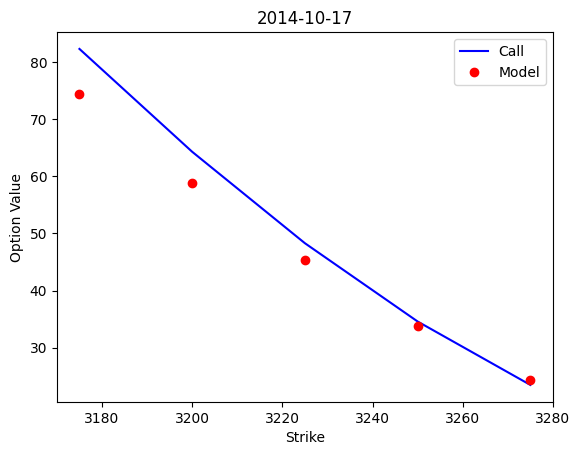

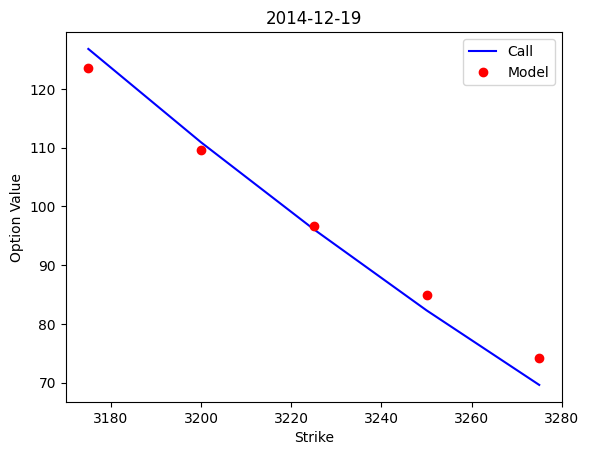

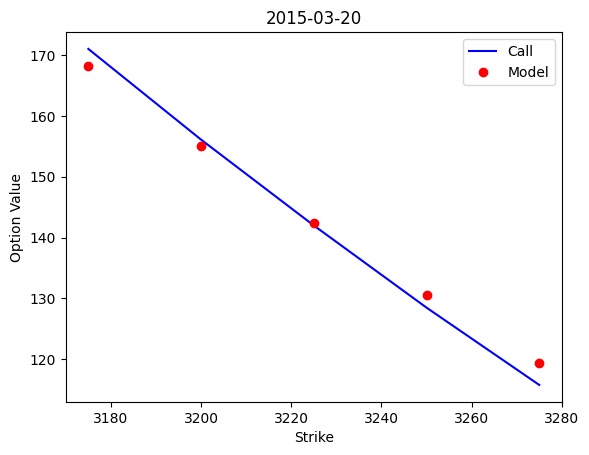

In [19]:
generate_plot(opt, options)

## **3. Conclusion**

This is all regarding Merton (1976) model calibration. We have basically repeated the process of the last module with Heston (1993) and adapted things to the Merton jump diffusion model. 

Now that you know how to properly calibrate somewhat simple models, we are going to make a step forward and look at a more complex one. Ideally, a model would incorporate stochastic volatility features present in Heston (1993), with the jump diffusion of Merton (1976). The question is, can we build a model that incorporates both of these desirable characteristics?

The answer is yes, and that's what we will begin to explore in the next lesson.

\
**References**

- Hilpisch, Yves. *Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging.* John Wiley & Sons, 2015.

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
